# Прогноз отказа мотор на основе показаний датчиков.

Описание данных :
- id -- идентификатор мотора
- cycle -- цикл работы
- p00-p20 -- показания датчиков считываемые в процессе работы
- s0, s1 -- настройки изменяемые в конце каждого цикла

**Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.**
Считаем, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Нужно предложить варианты использования полученной модели на практике.

**Доп. задание**: предложить альтернативную постановку задачи прогноза отказа моторов.

....................................................................................................................

## 1) Постановка задачи

По имеющимся данным будем решать задачу регрессии: **таргет** - максимальный цикл работы мотора. 

Для каждого мотора определен свой ожидаемый срок эксплуатации. Независимо от внешних факторов в процессе работы детали и связующие любого устройства претерпевают износ. 

При этом есть вероятность, что режим работы и эксплуатации мотора влияют на его долговечность. Такие явления как перегрев, повышенное давление, недостаток смазочных средств или кислородное голодание двигателя могут существенно снизить среднее время жизни одного из элементов или всего устройства. Такие обстоятельства на производстве ведут к потере времени, простою, нарушению производственной цепи и к соответсвующим экономическим последствиям на предприятии.

Таким, образом есть потребность в прогнозировании ожидаемого дня отказа мотора для его своевременной замены или ремонта комплектующих.

### Импорт библиотек

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score

## 2) Обработка данных

Посмотрим на сырые данные

In [8]:
data_raw = pd.read_csv('data/data.csv')
data_raw

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


Датасет представляет собой аналог временного ряда отсортированный по индентификатору мотора.

Некоторые признаки содержат константы, удалим такие столбцы.

Добавим в датасет признаки дифференцирования, характеризующие скорость изменения показаний датчиков.
 - **разность между рядом и его сдвинутой копией**  для каждого признака **кроме id и cycle**

Получаем еще 17 признаков в нашу выборку

1) Сгенерируем стандартные статистические признаки для задачи поиска аномалий. Будем использовать такие характеристики ряда как :
- максимум, минимум, среднее, медиана, стандартное отклонение, квантиль, взвешенный диапазон
- количество случаев выхода признака за доверительный интервал порядка альфа

2) Странно было бы использовать признаки полученные за весь срок эксплуатации мотора. Это могло бы привести к переобучению. 
Действительно, если средний срок эксплуатации мотора = 200 циклов, то , обучив модель на выборке по всем циклам, модель будет давать плохие прогнозы на данных, когда мотор еще работает и текущий цикл = 100.

А предсказывать срок службы уже сломанного мотора нет никакого смысла.

3) Учитывая это, будем обучать модель на окнах гибкой ширины. Для этого нужно при агрегировании данных ввести ограничение на длину используемого ряда. Реализуем это.

**Класс препроцессор**

In [59]:
class WindowPreprocessor:
    '''Class for preprocess raw data_series frame into aggregated dataset.
    Uses fixed window for preprocessing.
    '''
    
    def __init__(self, data_series, target=None, groupby_id=None, window_length=None, statistics=None):
        self.data_series = data_series
        self.target = target or 'cycle'
        self.gby_id = groupby_id or 'id'
        self.window_length = window_length
        self.statistics = statistics or ['max', 'min', 'mean', 'median', 'std', 'quantile', 'share']
        
        
    def fit_transform(self):
        gby_id = self.gby_id
        target = self.target
        window_length = self.window_length
        statistics = self.statistics
        
        train_columns = self.data_series.columns
        
        # Init train data and its index
        if window_length==None:
            train_data = self.data_series.copy()
        else:
            mask = self.data_series[self.target] <= window_length
            train_data = self.data_series[mask].copy()
            del mask
        
        train_index = train_data.index

        # Init statistic functions
        statistics = self.statistics
        
        transformed = pd.DataFrame()
        
        # Create max_target from target - final target for ML task
        transformed['max_' + target] = self.data_series.groupby(gby_id)[target].max()
        
        # Delete const columns
        for column in train_columns:
            # But not target! 
            if column != 'max_' + target:
                if len(train_data[column].unique())==1:
                    train_data.drop(columns=column, inplace=True)
                    
        for column in train_columns:
            if column not in [gby_id, target]:
                train_data['dif_' + column] = np.insert(np.diff(train_data[column]),0,0)
        
        # Exclude target from feature creating
        for column in train_columns:
            if (column != target) & (column != gby_id):
                
                # Create statistical features
                if 'max' in statistics:
                    transformed['max_' + column] = train_data.groupby(gby_id)[column].max()
                if 'min' in statistics:
                    transformed['min_' + column] = train_data.groupby(gby_id)[column].min()
                if 'mean' in statistics:
                    transformed['mean_' + column] = train_data.groupby(gby_id)[column].mean()
                if 'median' in statistics:
                    transformed['median_' + column] = train_data.groupby(gby_id)[column].median()
                if 'std' in statistics:
                    transformed['std_' + column] = train_data.groupby(gby_id)[column].std()
                if 'share' in statistics:
                    transformed['share_' + column] = (transformed['max_' + column] - transformed['min_' + column])\
                                                     /transformed['std_' + column]
                    
                # Create quantile features 
                if 'quantile' in statistics:
                    for quant in [0.9, 0.95, 0.97, 0.99]:    
                        # Right, left quantile column_name
                        right_qname = 'q(' + column + ', ' + str(round(quant, 3)) + ')'
                        left_qname = 'q(' + column + ', ' + str(round(1 - quant, 3))  + ')'
                        # Calulate quantiles 
                        transformed[right_qname] = train_data.groupby(gby_id)[column].quantile(quant)
                        transformed[left_qname] = train_data.groupby(gby_id)[column].quantile(1 - quant)
                        
                        # Number of cases greater or smaller than quantile. Names
                        grt_qname = 'grt_q_('+ column + ', ' + str(round(quant, 3)) + ')'
                        lss_qname = 'lss_q_('+ column + ',  = ' + str(round(1 - quant, 3)) + ')'
                        
                        # Count
                        mask_lss =  train_data[column] <\
                                    self.data_series.groupby(gby_id)[column].transform('quantile', 1 - quant)[train_index]
                        
                        mask_grt =  train_data[column] >\
                                    self.data_series.groupby(gby_id)[column].transform('quantile', quant)[train_index]
                                        
                        transformed[lss_qname] = train_data[mask_lss].groupby('id')[column].count()
                        transformed[grt_qname] = train_data[mask_grt].groupby('id')[column].count()

                        del mask_lss, mask_grt
                        
            
            
            
            # Fillna with 0. Number of cases greater or smaller than quantile = 0
            transformed = transformed.fillna(0)
            
            # Delete const columns
            for column in transformed.columns:
                # But not target! 
                if column != 'max_' + target:
                    if len(transformed[column].unique())==1:
                        transformed.drop(columns=column, inplace=True)
            
            self.transformed = transformed
            
        return transformed
        

        

**Проверяем работу функций**

In [61]:
pr = WindowPreprocessor(data_raw, window_length=100)
check_data = pr.fit_transform()
check_data

,max_cycle,max_p02,min_p02,mean_p02,median_p02,std_p02,share_p02,"q(p02, 0.9)","q(p02, 0.1)","lss_q_(p02, = 0.1)",...,"lss_q_(dif_dif_s2, = 0.05)","grt_q_(dif_dif_s2, 0.95)","q(dif_dif_s2, 0.97)","q(dif_dif_s2, 0.03)","lss_q_(dif_dif_s2, = 0.03)","grt_q_(dif_dif_s2, 0.97)","q(dif_dif_s2, 0.99)","q(dif_dif_s2, 0.01)","lss_q_(dif_dif_s2, = 0.01)","grt_q_(dif_dif_s2, 0.99)"
id,,,,,,,,,,,,,,,,,,,,,
1,192,47.64,47.03,47.3318,47.335,0.122139,4.994309,47.470,47.159,19,...,7,4,0.001306,-0.001300,2.0,3.0,0.001502,-0.001501,1.0,1.0
2,287,47.38,46.93,47.1575,47.170,0.087321,5.153385,47.251,47.030,25,...,5,4,0.001500,-0.001500,4.0,4.0,0.001602,-0.001602,2.0,2.0
3,179,47.51,46.94,47.2838,47.285,0.108979,5.230387,47.431,47.140,16,...,5,3,0.001006,-0.001300,2.0,2.0,0.001302,-0.001601,2.0,1.0
4,189,47.70,47.15,47.3788,47.370,0.106887,5.145626,47.520,47.260,18,...,6,5,0.001300,-0.001306,3.0,4.0,0.001401,-0.001701,2.0,2.0
5,269,47.46,46.97,47.1848,47.185,0.109429,4.477789,47.321,47.048,25,...,7,6,0.001300,-0.001400,4.0,4.0,0.001602,-0.001500,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,210,47.91,47.32,47.5490,47.555,0.124402,4.742704,47.700,47.389,20,...,7,7,0.001303,-0.001400,4.0,3.0,0.001400,-0.001600,2.0,0.0
77,154,48.00,47.25,47.5270,47.520,0.128602,5.831963,47.660,47.389,16,...,3,5,0.001306,-0.001212,3.0,3.0,0.001601,-0.001602,1.0,2.0
78,231,47.50,46.90,47.1641,47.160,0.114107,5.258225,47.300,47.030,22,...,4,2,0.001200,-0.001200,1.0,2.0,0.001302,-0.001201,0.0,0.0


Получили 1086 признаков, неплохо (если забыть о том факте, что большAя часть признаков сильно скоррелированны и зашумлены).

Отбором признаков пока заниматься не будем. Построим наконец модель регрессии.

## 3) Построение модели

Поскольку R2 метрика в задаче регрессии самая распространенная и легко интерпретируемая, возьмем именно ее для оценки качества построенной модели. Но перед этим вспомним, что данная метрика очень чувствительная к выбросам в данных. Поэтому исключим из выборки моторы которые проработали очень долго или очень мало по сравнению со всей выборкой. Возьмем доверительный интервал порядка 0.05

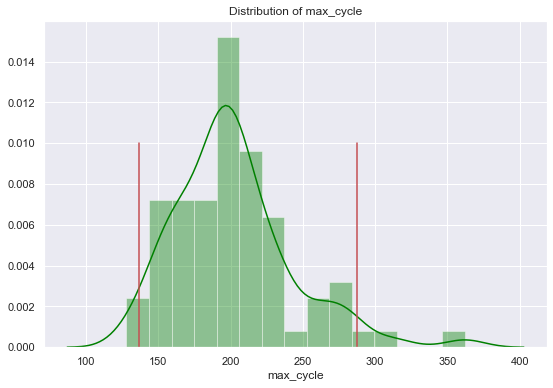

In [62]:
#Select target in [0.025,0.975] interval
y = check_data['max_cycle']
y_select = y[(y.quantile(0.025) < y) & (y < y.quantile(0.975))]
select_index = y_select.index

xleft = y.quantile(0.025)
xright = y.quantile(0.975)
          
plt.figure(figsize=(9,6))
sns.distplot(y, bins=15, color = 'green')
plt.title('Distribution of max_cycle')
plt.plot([xleft,xleft],[0,0.01],'r')
plt.plot([xright,xright],[0,0.01],'r')
plt.show()

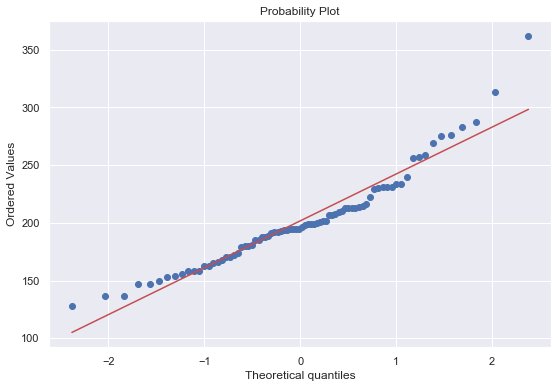

In [63]:
plt.figure(figsize=(9,6))
stats.probplot(y, plot=sns.mpl.pyplot)
plt.show()

Данных мало, сложно сказать как распределены значения таргета. От нормального распределения отличается. Критерий Шапиро-Уилка для такой выборки не применим

In [64]:
%%time
scaler = StandardScaler()

selected_scores = []
scores = [] 
for n in [50 + 10*x for x in range(25)]:
    curr_data = WindowPreprocessor(data_raw, window_length=n).fit_transform()
    X = curr_data.loc[y_select.index].drop(columns='max_cycle')

    X_scaled = scaler.fit_transform(X)
    
    # local feature selection based on Lasso
    lasso = Lasso(random_state=0).fit(X_scaled, y_select)
    model = SelectFromModel(lasso, prefit=True)
    X_new = model.transform(X_scaled)

    cv_score_selected = cross_val_score(LinearRegression(),
                                        X_new, y_select,
                                        scoring='r2', cv=KFold(n_splits=5,random_state=0)).mean()
    
    cv_score = cross_val_score(LinearRegression(),
                               X_scaled, y_select,
                               scoring='r2', cv=KFold(n_splits=5,random_state=0)).mean()
    
    selected_scores.append(cv_score_selected)
    scores.append(cv_score)

Wall time: 2min 38s


Здесь нужно было обучать scaler только на обучающей выборке и трансформировать на всю. Но на r2 это сильно не влияет.

Так же локальный feature selection может вызвать переобучение. Возможное решение - выбор оптимального окна для обучения и отбор признаков на нем. 

Сводим результаты в единую таблицу.

In [65]:
r2_table = pd.DataFrame([selected_scores,scores],
                        index = ['with selection','without'], 
                        columns = ['n_cycls='+str(x) for x in[50 + 10*x for x in range(25)]])

### Результаты

In [66]:
r2_table

,n_cycls=50,n_cycls=60,n_cycls=70,n_cycls=80,n_cycls=90,n_cycls=100,n_cycls=110,n_cycls=120,n_cycls=130,n_cycls=140,...,n_cycls=200,n_cycls=210,n_cycls=220,n_cycls=230,n_cycls=240,n_cycls=250,n_cycls=260,n_cycls=270,n_cycls=280,n_cycls=290
with selection,0.629711,-0.756701,0.604219,0.887360,0.940622,0.888596,0.949339,0.967154,0.975282,0.984319,...,0.990710,0.991612,0.994448,0.993249,0.992627,0.991563,0.992311,0.991241,0.988799,-7.057383e+20
without,-0.203243,-0.027054,0.285799,0.486562,0.604632,0.678526,0.792192,0.844404,0.853105,0.863680,...,0.936526,0.953594,0.967990,0.973898,0.978781,0.980983,0.981769,0.981210,0.982032,9.844564e-01


Построим график заисимости R2 от количества использованных циклов для обучения.

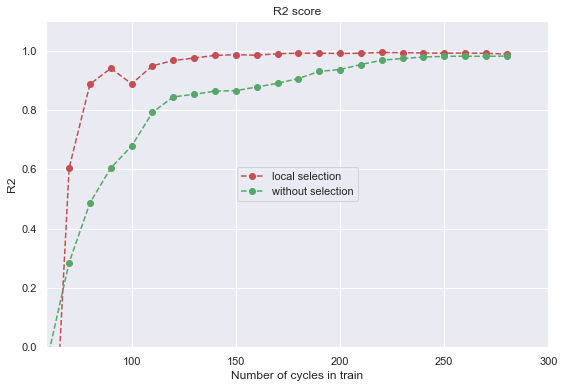

In [69]:
X_plot = [50 + 10*x for x in range(25)][:-1]
y_plot_0 = r2_table.iloc[0][:-1]
y_plot_1 = r2_table.iloc[1][:-1]

plt.figure(figsize=(9,6))
plt.plot(X_plot,y_plot_0,'ro--', label='local selection')
plt.plot(X_plot,y_plot_1,'go--', label='without selection')
plt.xlim(59,300)
plt.ylim(0,1.1)
plt.legend(loc='center')
plt.title('R2 score')
plt.xlabel('Number of cycles in train')
plt.ylabel('R2')
plt.show()

Алгоритм показывает приемлемый скор начиная от числа циклов равных 100. До этого момента продолжительность жизни мотора апроксимируем средним по выборке, с накоплением данных со счетчиков, корректируем прогноз по дате отказа. 

### Пути улучшения
- отбор признаков
- поиск по сетке (grid_search)
- перебор других моделей регресси : lasso, tree, randomforest, tree boosting
- подбор оптимального окна
- добавить признак - текущий цикл работы (чем больше - тем выше вероятность поломки, опасность переобучения)

### Альтернативная постановка

- прогноз вероятности поломки на следующий день, неделю, месяц
- решаем задачу классификации : таргет - поломка в указанный период - 1, продолжает работать - 0
